In [125]:
import numpy as np
from matplotlib import pyplot as plt
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
import os
import sys
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
from mpl_toolkits.mplot3d import Axes3D
from astropy.cosmology import WMAP9 as cosmo
from astropy.constants import c
%matplotlib inline

# Reading In HyperLeda File

In [126]:
#Get current path so program can tell if this is being run on Kelly's or Rose's computer
mypath=os.getcwd()
if mypath.find('rfinn') > -1:
    print "Running on Rose's computer"
elif mypath.find('kelly') > -1:
    print "Running on Kellys's computer"
    hlext = '/Users/kellywhalen/RESEARCH/'
    nsapath = '/Users/kellywhalen/RESEARCH/NSA_table/'

#NSA Table
#NSA_file = nsapath+'nsa_v0_1_2.fits'
#nsa = fits.getdata(NSA_file)
#nsa = nsa[0:21]
#nsadict=dict((a,b) for a,b in zip(nsa.NSAID,np.arange(len(nsa.NSAID))))


Running on Kellys's computer


In [131]:
quad1 = hlext + 'HLquad1.cgi'
quad1 = np.loadtxt(quad1, skiprows = 1, dtype = {'names':('al2000','de2000','vopt'), 'formats':(np.float, np.float, np.float)}, delimiter = '|')

quad2 = hlext + 'HLquad2.cgi'
quad2 = np.loadtxt(quad2, dtype = {'names':('al2000','de2000','vopt'), 'formats':(np.float, np.float, np.float)}, delimiter = '|')

quad3 = hlext + 'HLquad3.cgi'
quad3 = np.loadtxt(quad3, dtype = {'names':('al2000','de2000','vopt'), 'formats':(np.float, np.float, np.float)}, delimiter = '|')

quad4 = hlext + 'HLquad4.cgi'
quad4 = np.loadtxt(quad4, dtype = {'names':('al2000','de2000','vopt'), 'formats':(np.float, np.float, np.float)}, delimiter = '|')


hlcat = np.append(quad1, quad2)
hlcat = np.append(hlcat, quad3)
hlcat = np.append(hlcat, quad4)


# Mould Flow Model

In [148]:
c = 3.e5*u.km/u.s

ra = hlcat['al2000']
dec = hlcat['de2000']
v = hlcat['vopt']*u.km/u.second


# define nsa RA and Dec as SkyCoord
nsa_sc = SkyCoord(ra*u.hourangle, dec*u.degree)
ra = nsa_sc.ra.degree

# convert helio-centric velocity to units of km/s
V_H = v

# 1. correction of observed heliocentric velocity to centroid of local group
# VLG = VH - 79 cos l cos b + 296 sin l cos b - 36 sin b

V_LG = - 79.*u.km/u.second*np.cos(nsa_sc.galactic.l.radian)*np.cos(nsa_sc.galactic.b.radian) + 296.*u.km/u.second*np.sin(nsa_sc.galactic.l.radian)*np.cos(nsa_sc.galactic.b.radian) - 36.*u.km/u.second*np.sin(nsa_sc.galactic.b.radian)

# from Mould+2000, ApJ, 529, 786
# not sure if we are using this equation exactly right

V_fid = 200.*u.km/u.second # infall of LG into Virgo?
# Virgo coordinates given by Mould+2000
Virgo = SkyCoord('12h28m19s', '+12d40m00s', frame='fk5',equinox='J1950.') # epoch = 1950
Virgo = Virgo.transform_to(FK5(equinox='J2000'))
### need to fix this to use spherical distance
#theta = np.sqrt((nsa_sc.ra.radian - Virgo.ra.radian)**2 + (nsa_sc.dec.radian - Virgo.dec.radian)**2)
theta = Virgo.separation(nsa_sc).radian 
# cluster radius in deg
gamma = 2.

V_a = 1035.*u.km/u.second # recession vel of Virgo from Mould+2000
#V_a = 1221.*u.km/u.second # recession vel of Virgo as calculated by Gianluca
V_o = V_H + V_LG # recession velocities of the galaxies
r_oa = np.sqrt(V_o**2 + V_a**2 - 2.*V_o*V_a*np.cos(theta))
#membflag = (nsa.Z*3.e5 < (3000-200*theta)) & (nsa.Z*3.e5 > (2*V_a/(u.km/u.s) - (3000-200*theta)))& (theta < 10.)
#V_infall = V_fid*(np.cos(theta) + (V_o - V_a*np.cos(theta))/r_oa*(r_oa/V_a)**(1-gamma))
#V_infall[membflag] = 0.

V_fid = 400.*u.km/u.second # infall of LG into Virgo?
# GA coordinates given by Mould+2000
GA = SkyCoord('13h20m00s', '+44d00m00s', frame='fk5',equinox='J1950.') # epoch = 1950
GA = GA.transform_to(FK5(equinox='J2000'))
theta = GA.separation(nsa_sc).radian
#theta = np.sqrt((nsa_sc.ra.radian - GA.ra.radian)**2 + (nsa_sc.dec.radian - GA.dec.radian)**2)

gamma = 2.
V_a = 4380.*u.km/u.second # recession vel of Great Attractor from Mould+2000
V_o = V_H + V_LG # recession velocities of the galaxies
r_oa = np.sqrt(V_o**2 + V_a**2 - 2.*V_o*V_a*np.cos(theta))
V_GA = V_fid*(np.cos(theta) + (V_o - V_a*np.cos(theta))/r_oa*(r_oa/V_a)**(1-gamma))

# Final, correction cosmic velocity is
#
#  Vcosmic = VH + Vc,LG + Vin,Virgo + Vin,GA + Vin,Shap + ...

# ## Tranforming to Supergalactic Coordinates##
# 
# Looking to match the plots shown in Kim+2016
# 
# https://arxiv.org/abs/1611.00437

#Plot of Virgo Cluster in galactic coordinates
V_cosmic = V_H + V_LG  +V_GA #+ V_infall
V = V_cosmic

#SGX = V/cosmo.H(0)*np.cos(nsa_sc.supergalactic.sgl.radian)*np.cos(nsa_sc.supergalactic.sgb.radian)
#SGY = V/cosmo.H(0)*np.sin(nsa_sc.supergalactic.sgl.radian)*np.cos(nsa_sc.supergalactic.sgb.radian)
#SGZ = V/cosmo.H(0)*np.sin(nsa_sc.supergalactic.sgb.radian)


# using H0 = 74 to match Kim+2016 paper
#H0 = 74.*u.km/u.second/u.Mpc
H0 = 100.*u.km/u.second/u.Mpc #Kim's email
SGX = V/H0*np.cos(nsa_sc.supergalactic.sgl.radian)*np.cos(nsa_sc.supergalactic.sgb.radian)
SGY = V/H0*np.sin(nsa_sc.supergalactic.sgl.radian)*np.cos(nsa_sc.supergalactic.sgb.radian)
SGZ = V/H0*np.sin(nsa_sc.supergalactic.sgb.radian)

distance_to_virgo = 16.5*u.Mpc #Mpc
SGX_Virgo = distance_to_virgo*np.cos(Virgo.supergalactic.sgl.radian)*np.cos(Virgo.supergalactic.sgb.radian)
SGY_Virgo = distance_to_virgo*np.sin(Virgo.supergalactic.sgl.radian)*np.cos(Virgo.supergalactic.sgb.radian)
SGZ_Virgo = distance_to_virgo*np.sin(Virgo.supergalactic.sgb.radian)

# difference 
DSGX = SGX - SGX_Virgo
DSGY = SGY - SGY_Virgo
DSGZ = SGZ - SGZ_Virgo

distV = np.sqrt(DSGX**2 + DSGY**2 + DSGZ**2)

In [149]:
####Apply Virgo flow correction to everything not in Virgo
notclustermemb = distV > 4.*u.Mpc


V_fid = 200.*u.km/u.second # infall of LG into Virgo?
# Virgo coordinates given by Mould+2000
Virgo = SkyCoord('12h28m19s', '+12d40m00s', frame='fk5',equinox='J1950.') # epoch = 1950
Virgo = Virgo.transform_to(FK5(equinox='J2000'))
### need to fix this to use spherical distance
#theta = np.sqrt((nsa_sc.ra.radian - Virgo.ra.radian)**2 + (nsa_sc.dec.radian - Virgo.dec.radian)**2)
theta = Virgo.separation(nsa_sc).radian 
# cluster radius in deg
gamma = 2.

V_a = 1035.*u.km/u.second # recession vel of Virgo from Mould+2000
#V_a = 1221.*u.km/u.second # recession vel of Virgo as calculated by Gianluca
V_o = V_H + V_LG # recession velocities of the galaxies
r_oa = np.sqrt(V_o**2 + V_a**2 - 2.*V_o*V_a*np.cos(theta))
#membflag = (nsa.Z*3.e5 < (3000-200*theta)) & (nsa.Z*3.e5 > (2*V_a/(u.km/u.s) - (3000-200*theta)))& (theta < 10.)
#V_infall = V_fid*(np.cos(theta) + (V_o - V_a*np.cos(theta))/r_oa*(r_oa/V_a)**(1-gamma))
#V_infall[membflag] = 0.



V_infall = np.zeros(len(notclustermemb))*(u.km/u.s)
V_infall[notclustermemb] =  V_fid*(np.cos(theta[notclustermemb]) + (V_o[notclustermemb] - V_a*np.cos(theta[notclustermemb]))/r_oa[notclustermemb]*(r_oa[notclustermemb]/V_a)**(1-gamma))


V_cosmic = V_H + V_LG  +V_GA + V_infall
V = V_cosmic

H0 = 100.*u.km/u.second/u.Mpc #Kim's email
SGX = V/H0*np.cos(nsa_sc.supergalactic.sgl.radian)*np.cos(nsa_sc.supergalactic.sgb.radian)
SGY = V/H0*np.sin(nsa_sc.supergalactic.sgl.radian)*np.cos(nsa_sc.supergalactic.sgb.radian)
SGZ = V/H0*np.sin(nsa_sc.supergalactic.sgb.radian)

distance_to_virgo = 16.5*u.Mpc #Mpc
SGX_Virgo = distance_to_virgo*np.cos(Virgo.supergalactic.sgl.radian)*np.cos(Virgo.supergalactic.sgb.radian)
SGY_Virgo = distance_to_virgo*np.sin(Virgo.supergalactic.sgl.radian)*np.cos(Virgo.supergalactic.sgb.radian)
SGZ_Virgo = distance_to_virgo*np.sin(Virgo.supergalactic.sgb.radian)

# difference 
DSGX = SGX - SGX_Virgo
DSGY = SGY - SGY_Virgo
DSGZ = SGZ - SGZ_Virgo

distV = np.sqrt(DSGX**2 + DSGY**2 + DSGZ**2)

# Plots

## Kim Figure 1

[240.0, 115.0, -35.0, 60.0]

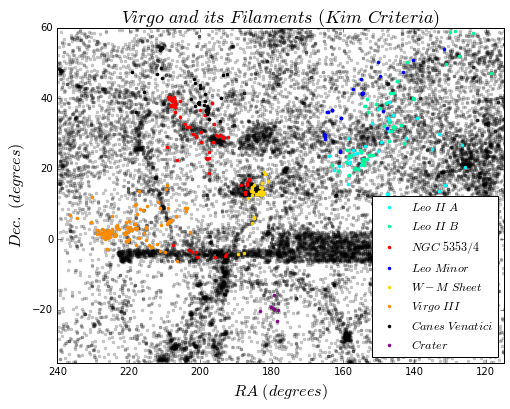

In [166]:

#vflag = raflag & decflag & velflag 
#c = 3.e5
#z = nsa.Z

leoIIa = (SGX > 0.21*u.Mpc) & (SGX < 10.36*u.Mpc) & (SGY > 9.26*u.Mpc) & (SGY < 15.05*u.Mpc) & (SGZ > -15.47*u.Mpc) & (SGZ < -4.16*u.Mpc) & (v > 1171*u.km/u.second) & (v < 2267*u.km/u.second)
leoIIb = (SGX > 0.30*u.Mpc) & (SGX < 15.65*u.Mpc) & (SGY > 10.90*u.Mpc) & (SGY < 14.56*u.Mpc) & (SGZ > -9.88*u.Mpc) & (SGZ < -3.51*u.Mpc) & (v >  1257*u.km/u.second) & (v < 2267*u.km/u.second)
leominor = (SGX > 0.55*u.Mpc) & (SGX < 5.89*u.Mpc) & (SGY > 4.11*u.Mpc) & (SGY < 6.49*u.Mpc) & (SGZ > -2.61*u.Mpc) & (SGZ < -0.99*u.Mpc) & (v >  505*u.km/u.second) & (v < 772*u.km/u.second)
ngc = (SGX > -16.04*u.Mpc) & (SGX < 4.23*u.Mpc) & (SGY > 18. *u.Mpc) & (SGY < 26.53*u.Mpc) & (SGZ > -1.19 *u.Mpc) & (SGZ < 8.92*u.Mpc) & (v >  2268*u.km/u.second) & (v < 3238*u.km/u.second) #(SGY > 21.71 *u.Mpc)
wm = (SGX > -13.38*u.Mpc) & (SGX < -1.66*u.Mpc) & (SGY > 16.03  *u.Mpc) & (SGY < 24.99*u.Mpc) & (SGZ > -3.10 *u.Mpc) & (SGZ < -1.10*u.Mpc) & (v > 1806*u.km/u.second) & (v < 2968*u.km/u.second)
vIII = (SGX > -10.56*u.Mpc) & (SGX < -3.91*u.Mpc) & (SGY >  9.50  *u.Mpc) & (SGY < 15.57*u.Mpc) & (SGZ >  2.35 *u.Mpc) & (SGZ < 11.72*u.Mpc) & (v > 1160*u.km/u.second) & (v < 2196*u.km/u.second)
canes = (SGX > 0.78 *u.Mpc) & (SGX < 4.37*u.Mpc) & (SGY >   6.88   *u.Mpc) & (SGY < 13.92*u.Mpc) & (SGZ >  1.38  *u.Mpc) & (SGZ < 4.80*u.Mpc) & (v >   674*u.km/u.second ) & (v < 1446*u.km/u.second)
crater = (SGX > -12.25 *u.Mpc) & (SGX < -4.62*u.Mpc) & (SGY >   8.36   *u.Mpc) & (SGY < 12.70*u.Mpc) & (SGZ >  -5.91  *u.Mpc) & (SGZ < -2.98*u.Mpc) & (v >   1436*u.km/u.second ) & (v < 1903*u.km/u.second)


#our values
myngc = (SGX > -16.04*u.Mpc) & (SGX < 4.23*u.Mpc) & (SGY > 23.5 *u.Mpc) & (SGY < 30.*u.Mpc) & (SGZ > -1.19 *u.Mpc) & (SGZ < 8.92*u.Mpc) & (v >  2268*u.km/u.second) & (v < 3238*u.km/u.second)
mywm = (SGX > -13.38*u.Mpc) & (SGX < -1.66*u.Mpc) & (SGY > 23.  *u.Mpc) & (SGY < 26.*u.Mpc) & (SGZ > -3.10 *u.Mpc) & (SGZ < -1.10*u.Mpc) & (v > 1806*u.km/u.second) & (v < 2968*u.km/u.second)


plt.figure(figsize = (8,6))
plt.plot(ra, dec, 'k.', alpha=0.2)
plt.plot(ra[leoIIa], dec[leoIIa], color = 'aqua', marker = '.', linestyle = 'None', label = '$Leo\ II\ A$')
plt.plot(ra[leoIIb], dec[leoIIb], color = 'mediumspringgreen', marker = '.', linestyle = 'None', label = '$Leo\ II\ B$')  
plt.plot(ra[ngc], dec[ngc], 'r.', label = '$NGC\ 5353/4$') 
plt.plot(ra[leominor], dec[leominor], 'b.', label = '$Leo\ Minor$') 
plt.plot(ra[wm], dec[wm], color = 'gold', marker = '.', linestyle = 'None', label = '$W-M\ Sheet$')
plt.plot(ra[vIII], dec[vIII], color = 'darkorange', marker = '.', linestyle = 'None', label = '$Virgo \ III$')
plt.plot(ra[canes], dec[canes], 'k.', label = '$Canes\ Venatici$')
plt.plot(ra[crater], dec[crater], color = 'darkmagenta', marker = '.', linestyle = 'None', label = '$Crater$')

plt.xlabel('$RA\ (degrees)$', fontsize = 16)
plt.ylabel('$Dec.\ (degrees)$', fontsize = 16)
plt.title('$Virgo\ and \ its \ Filaments\ (Kim\ Criteria)$', fontsize = 18)
plt.legend(loc='lower right', numpoints = 1)
plt.gca().invert_xaxis()
plt.axis([240.,115.,-35.,60.])
#plt.savefig('virgofilaments.png')

## Kim Figure 2

[-15.0, 15.0, -10.0, 15.0]

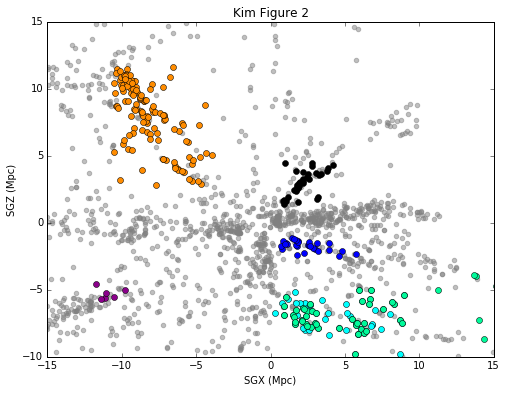

In [167]:
flag416 = (SGY > 4*u.Mpc) & (SGY < 16*u.Mpc) #for fig 2

plt.figure(figsize = (8,6))
plt.scatter(SGX[flag416],SGZ[flag416], color = 'gray',alpha=.5)
plt.plot(SGX[leoIIa], SGZ[leoIIa], color = 'aqua', marker = 'o', linestyle = 'None', label = '$Leo\ II\ A$')
plt.plot(SGX[leoIIb], SGZ[leoIIb], color = 'mediumspringgreen', marker = 'o', linestyle = 'None', label = '$Leo\ II\ B$')  
plt.plot(SGX[leominor], SGZ[leominor], 'bo', label = '$Leo\ Minor$')
#plt.plot(SGX[ngc], SGZ[ngc], 'ro', label = '$NGC\ 5353/4$') 
#plt.plot(SGX[wm], SGZ[wm], color = 'gold', marker = 'o', linestyle = 'None', label = '$W-M\ Sheet$')
plt.plot(SGX[vIII], SGZ[vIII], color = 'darkorange', marker = 'o', linestyle = 'None', label = '$Virgo \ III$')
plt.plot(SGX[crater], SGZ[crater], color = 'darkmagenta', marker = 'o', linestyle = 'None', label = '$Crater$')
plt.plot(SGX[canes], SGZ[canes], 'ko', label = '$Canes\ Venatici$')
plt.axis([-15,10,-10,20])
plt.xlabel('SGX (Mpc)')
plt.ylabel('SGZ (Mpc)')
plt.title('Kim Figure 2')
plt.axis([-15.,15.,-10.,15.])

## Kim Figure 3

[-18.0, 7.0, -10.0, 15.0]

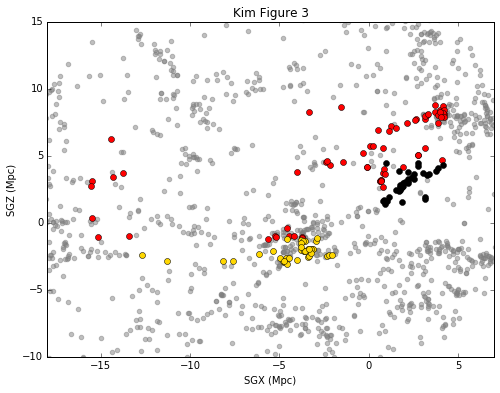

In [168]:
flag1627 = (SGY > 16*u.Mpc) & (SGY < 40*u.Mpc) #for fig 3

plt.figure(figsize = (8,6))
plt.scatter(SGX[flag1627],SGZ[flag1627], color = 'gray', alpha=.5)
#plt.plot(SGX[leoIIa], SGZ[leoIIa], color = 'aqua', marker = 'o', linestyle = 'None', label = '$Leo\ II\ A$')
#plt.plot(SGX[leoIIb], SGZ[leoIIb], color = 'mediumspringgreen', marker = 'o', linestyle = 'None', label = '$Leo\ II\ B$')  
plt.plot(SGX[ngc], SGZ[ngc], 'ro', label = '$NGC\ 5353/4$') 
plt.plot(SGX[wm], SGZ[wm], color = 'gold', marker = 'o', linestyle = 'None', label = '$W-M\ Sheet$')
#plt.plot(SGX[vIII], SGZ[vIII], color = 'darkorange', marker = 'o', linestyle = 'None', label = '$Virgo \ III$')
plt.plot(SGX[canes], SGZ[canes], 'ko', label = '$Canes\ Venatici$')
plt.axis([-15,10,-10,20])
plt.xlabel('SGX (Mpc)')
plt.ylabel('SGZ (Mpc)')
plt.title('Kim Figure 3')
plt.axis([-18.,7.,-10.,15.])


In [137]:
c1 = SkyCoord(115*u.degree, 0*u.degree)
c2 = SkyCoord(240*u.degree, 0*u.degree)

print c1.ra.hourangle
print c2.ra.hourangle

7.66666666667
16.0


In [143]:
print ra

[ 7.67994  8.10954  8.10449 ...,  8.39506  8.39774  8.36189]
